In [ ]:
!pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import nltk
import gensim
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
!wget -c https://firebasestorage.googleapis.com/v0/b/william-personal-firebase.appspot.com/o/chatbot.zip?alt=media&token=f30ea369-1ffc-4163-baef-45b2e2f883c6 
!unzip /content/chatbot.zip?alt=media

In [ ]:
df = pd.read_csv('/content/archive/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv')
df

,flags,utterance,category,intent
0,BILC,"I don't have an online account, what do I have...",ACCOUNT,create_account
1,BILQZ,can you tell me if i can regisger two accounts...,ACCOUNT,create_account
2,BPLC,"I have no online account, open one, please",ACCOUNT,create_account
3,BIPLD,"could you ask an agent how to open an account,...",ACCOUNT,create_account
4,BLQC,"i want an online account, create one",ACCOUNT,create_account
...,...,...,...,...
21529,BILQC,"i have no shipping address, what do i have to ...",SHIPPING,set_up_shipping_address
21530,BLQC,I have no shipping address and I want to set o...,SHIPPING,set_up_shipping_address
21531,BIQC,"i want to set up my shipping address, what do ...",SHIPPING,set_up_shipping_address
21532,BILC,"I don't have a shipping address, can you set o...",SHIPPING,set_up_shipping_address


Basic processing

In [ ]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

porter = PorterStemmer()
english_stopwords = stopwords.words('english')

# lower case, tokenize, stopword, puctuation and stemming
df['words'] = df['utterance'].str.lower()
df['words'] = df['words'].apply(word_tokenize)
df['words'] = df['words'].apply(lambda l: [porter.stem(word) for word in l if (word not in english_stopwords) and word.isalpha()])
print(df['words'].head())
print(df['words'].describe())

0                             [onlin, account, regist]
1    [tell, regisg, two, account, singl, email, add...
2                   [onlin, account, open, one, pleas]
3            [could, ask, agent, open, account, pleas]
4                   [want, onlin, account, creat, one]
Name: words, dtype: object
count           21534
unique          10836
top       [see, bill]
freq               31
Name: words, dtype: object


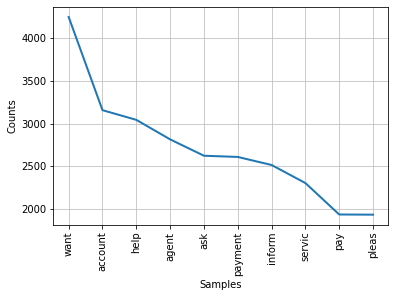

In [ ]:
from nltk.probability import FreqDist

fdist = FreqDist(df['words'].sum())
fdist.most_common(3)
fdist.plot(10)


Train test Split

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 1337)

Count vectorize

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# merged words list
train_words=[' '.join(text) for text in df_train['words']]
test_words=[' '.join(text) for text in df_test['words']]

# count
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(train_words).toarray()
X_test_counts = count_vectorizer.transform(test_words).toarray()

Ngram vectorize

In [ ]:
# ngram
ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
X_train_ng = ngram_vectorizer.fit_transform(train_words).toarray()
X_test_ng = ngram_vectorizer.transform(test_words).toarray()

In [ ]:
# tfidf
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False);
X_train_tfidf = transformer.fit_transform(X_train_counts);
X_test_tfidf = transformer.transform(X_test_counts);


In [ ]:
# pretrained word2vec
import gensim.downloader as api
wv_pretrain = api.load('word2vec-google-news-300')

[--------------------------------------------------] 1.2% 20.4/1662.8MB downloaded

KeyboardInterrupt: ignored

In [ ]:
# custom word2vec
import gensim
model_w2v = gensim.models.Word2Vec(sentences=df_train['words'])

In [ ]:
!wget https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz
!gzip -d glove.6B.100d.txt.gz

--2022-07-10 16:36:34--  https://github.com/allenai/spv2/raw/master/model/glove.6B.100d.txt.gz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/allenai/spv2/master/model/glove.6B.100d.txt.gz [following]
--2022-07-10 16:36:34--  https://media.githubusercontent.com/media/allenai/spv2/master/model/glove.6B.100d.txt.gz
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134409071 (128M) [application/octet-stream]
Saving to: ‘glove.6B.100d.txt.gz.1’

glove.6B.100d.txt.g 100%[===================>] 128.18M  86.1MB/s    in 1.5s    

2022-07-10 16:36:35 (86.1 MB/s) - ‘glove.6B.100d.txt.gz.1’ s

In [ ]:
# pretrained glove
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

glove_file = '/content/glove.6B.100d.txt'
tmp_file = "/content/glove_100d_word2vec.txt"

_ = glove2word2vec(glove_file, tmp_file)

glove_model = KeyedVectors.load_word2vec_format(tmp_file)


In [ ]:
# pretrained bert
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text # just needed tensorflow_text

bert_encoder_dir = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
bert_preprocess_dir = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_layer = hub.KerasLayer(bert_preprocess_dir)
bert_encode_model = hub.KerasLayer(bert_encoder_dir, trainable=True)

In [ ]:
# tokenized seq for keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['words'])
encoded_train_docs = tokenizer.texts_to_sequences(df_train['words'])
encoded_test_docs = tokenizer.texts_to_sequences(df_test['words'])
max_length = max([len(s) for s in df_train['words']])
X_train = pad_sequences(encoded_train_docs, 
                        maxlen=max_length, 
                        padding='post')
y_train = pd.get_dummies(df_train['category'])
X_test = pad_sequences(encoded_test_docs, 
                        maxlen=max_length, 
                        padding='post')
y_test = pd.get_dummies(df_test['category'])

Examples:

In [ ]:
# plsa using tfidf train data

from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;

def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

xtfidf_norm = normalize(X_train_tfidf, norm='l1', axis=1)
num_topics=10
plsa_model = NMF(n_components=num_topics, init='nndsvd');
plsa_model.fit(xtfidf_norm)
get_nmf_topics(plsa_model, 20)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10
0,payment,bill,account,agent,servic,order,help,want,invoic,check
1,problem,see,one,ask,custom,purchas,human,profil,see,deliveri
2,issu,tell,user,could,complaint,chang,need,know,tell,tell
3,pay,download,onlin,pleas,client,modifi,talk,cancel,get,option
4,make,request,creat,fuck,inform,track,speak,refund,download,packag
5,notifi,view,open,reimburs,contact,tell,contact,reimburs,request,shipment
6,report,obtain,regist,payment,email,product,someon,request,view,ticket
7,inform,lost,got,cancel,support,item,person,obtain,obtain,track
8,tri,get,hack,human,consum,someth,understand,get,receiv,statu
9,card,receiv,email,refund,lodg,pay,ca,postpon,inform,fee


In [ ]:
# word2vec + cnn
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def get_word2vec_embed_layer(max_length, tokenizer, wv):
  word_index = tokenizer.word_index
  embedding_mat = np.zeros((len(word_index)+1, 100))
  for word, i in word_index.items():
      try:
          vector = wv[word]
          embedding_mat[i] = vector
      except:
          continue
  word2vec_embedding_layer = Embedding(input_dim=embedding_mat.shape[0],
                                      output_dim=embedding_mat.shape[1], 
                                      weights=[embedding_mat],
                                      input_length=max_length, 
                                      trainable=False)
  return word2vec_embedding_layer

model_word2vec = Sequential()
model_word2vec.add(get_word2vec_embed_layer(max_length, tokenizer, model_w2v.wv)) # use wv_pretrain instead of model_w2v.wv for pretrain w2v
model_word2vec.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_word2vec.add(MaxPooling1D(pool_size=2))
model_word2vec.add(Flatten())
model_word2vec.add(Dense(11, activation='softmax'))
print(model_word2vec.summary())
model_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_word2vec.fit(X_train, y_train, epochs=10)
model_word2vec.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 100)           152100    
                                                                 
 conv1d (Conv1D)             (None, 9, 128)            64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 11)                5643      
                                                                 
Total params: 221,871
Trainable params: 69,771
Non-trainable params: 152,100
_____________________________________________

[0.019671788439154625, 0.9941955208778381]

In [ ]:
# bert + cnn
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_hub as hub

text_input = Input(shape=(), dtype=tf.string)
bert_inputs = bert_preprocess_layer(text_input)
outputs = bert_encode_model(bert_inputs)
net = outputs['pooled_output']
net = Dropout(0.1)(net)
net = Dense(11, activation='softmax')(net)
bert_model = Model(text_input, net)
bert_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
bert_model.fit(tf.constant(train_words), y_train, epochs=10)


Epoch 1/10
539/539 [==============================] - 279s 505ms/step - loss: 0.1170 - accuracy: 0.9680
Epoch 2/10
384/539 [====================>.........] - ETA: 1:13 - loss: 0.0277 - accuracy: 0.9941

KeyboardInterrupt: ignored

In [ ]:
# pretrained glove

def get_glove_embed_layer(max_length, tokenizer, wv):
  word_index = tokenizer.word_index
  embedding_glove_mat = np.zeros((len(word_index)+1, 100))
  for word, i in word_index.items():
      try:
          vector = glove_model[word]
          embedding_glove_mat[i] = vector
      except:
          continue
  glove_embedding_layer = Embedding(input_dim=embedding_glove_mat.shape[0],
                                      output_dim=embedding_glove_mat.shape[1], 
                                      weights=[embedding_glove_mat],
                                      input_length=max_length, 
                                      trainable=False)
  return glove_embedding_layer

model_glove = Sequential()
model_glove.add(get_glove_embed_layer(max_length, tokenizer, model_w2v.wv))
model_glove.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_glove.add(MaxPooling1D(pool_size=2))
model_glove.add(Flatten())
model_word2vec.add(Dense(11, activation='softmax'))
print(model_word2vec.summary())
model_word2vec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_word2vec.fit(X_train, y_train, epochs=10)
model_word2vec.evaluate(X_test, y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 13, 100)           152100    
                                                                 
 conv1d (Conv1D)             (None, 9, 128)            64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 11)                5643      
                                                                 
 dense_4 (Dense)             (None, 11)                132       
                                                        

[0.353883296251297, 0.855583906173706]